# TASK 1

### Для первого варианта (когда pdf-документ размечен) мы просто используем встроенную python-библиотеку. 

In [11]:
!pip install camelot-py
!pip install PyPDF2==2.9

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import camelot

In [2]:
file = 'table.pdf'

In [3]:
tables = camelot.read_pdf(file)

In [4]:
tables.n

1

In [5]:
tables[0].df

,0,1,2,3,4,5
0,Disability \nCategory,Participants,Ballots \nCompleted,Ballots \nIncomplete/ \nTerminated,Results,
1,,,,,Accuracy,Time to \ncomplete
2,Blind,5,1,4,"34.5%, n=1","1199 sec, n=1"
3,Low Vision,5,2,3,"98.3% n=2 \n(97.7%, n=3)","1716 sec, n=3 \n(1934 sec, n=2)"
4,Dexterity,5,4,1,"98.3%, n=4","1672.1 sec, n=4"
5,Mobility,3,3,0,"95.4%, n=3","1416 sec, n=3"


# TASK 2

### Во втором случае (Когда pdf-документ не размечен. Таблицы имеют отрисованные границы) задачу стоит решать совершенно иначе. 

Разобьем на подзадачи:

1) Научиться внутреннюю часть ячеек переводить в текст
2) Научиться находить границы ячеек таблиц
3) Создавать из этого DataFrame

## 1)

In [325]:
!pip install pytesseract

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pytesseract

import numpy as np

from PIL import Image
from pdf2image import convert_from_path

In [20]:
images = convert_from_path('table.pdf')
image = np.array(images[0])

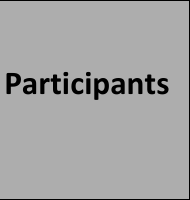

In [21]:
Image.fromarray(image[400:600, 460:650]).convert('L')

In [22]:
print(pytesseract.image_to_string(Image.fromarray(image[400:600, 460:650]).convert('L')))

Participants

 



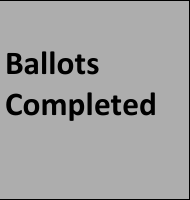

In [23]:
Image.fromarray(image[400:600, 660:850]).convert('L')

In [24]:
print(pytesseract.image_to_string(Image.fromarray(image[400:600, 660:850]).convert('L')))

Ballots
Completed

 



## 2)

In [18]:
!pip install pdf2image

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [47]:
import cv2

import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy

In [48]:
images = convert_from_path('test.pdf')
image = np.array(images[0])

In [49]:
image.shape

(1653, 2339, 3)

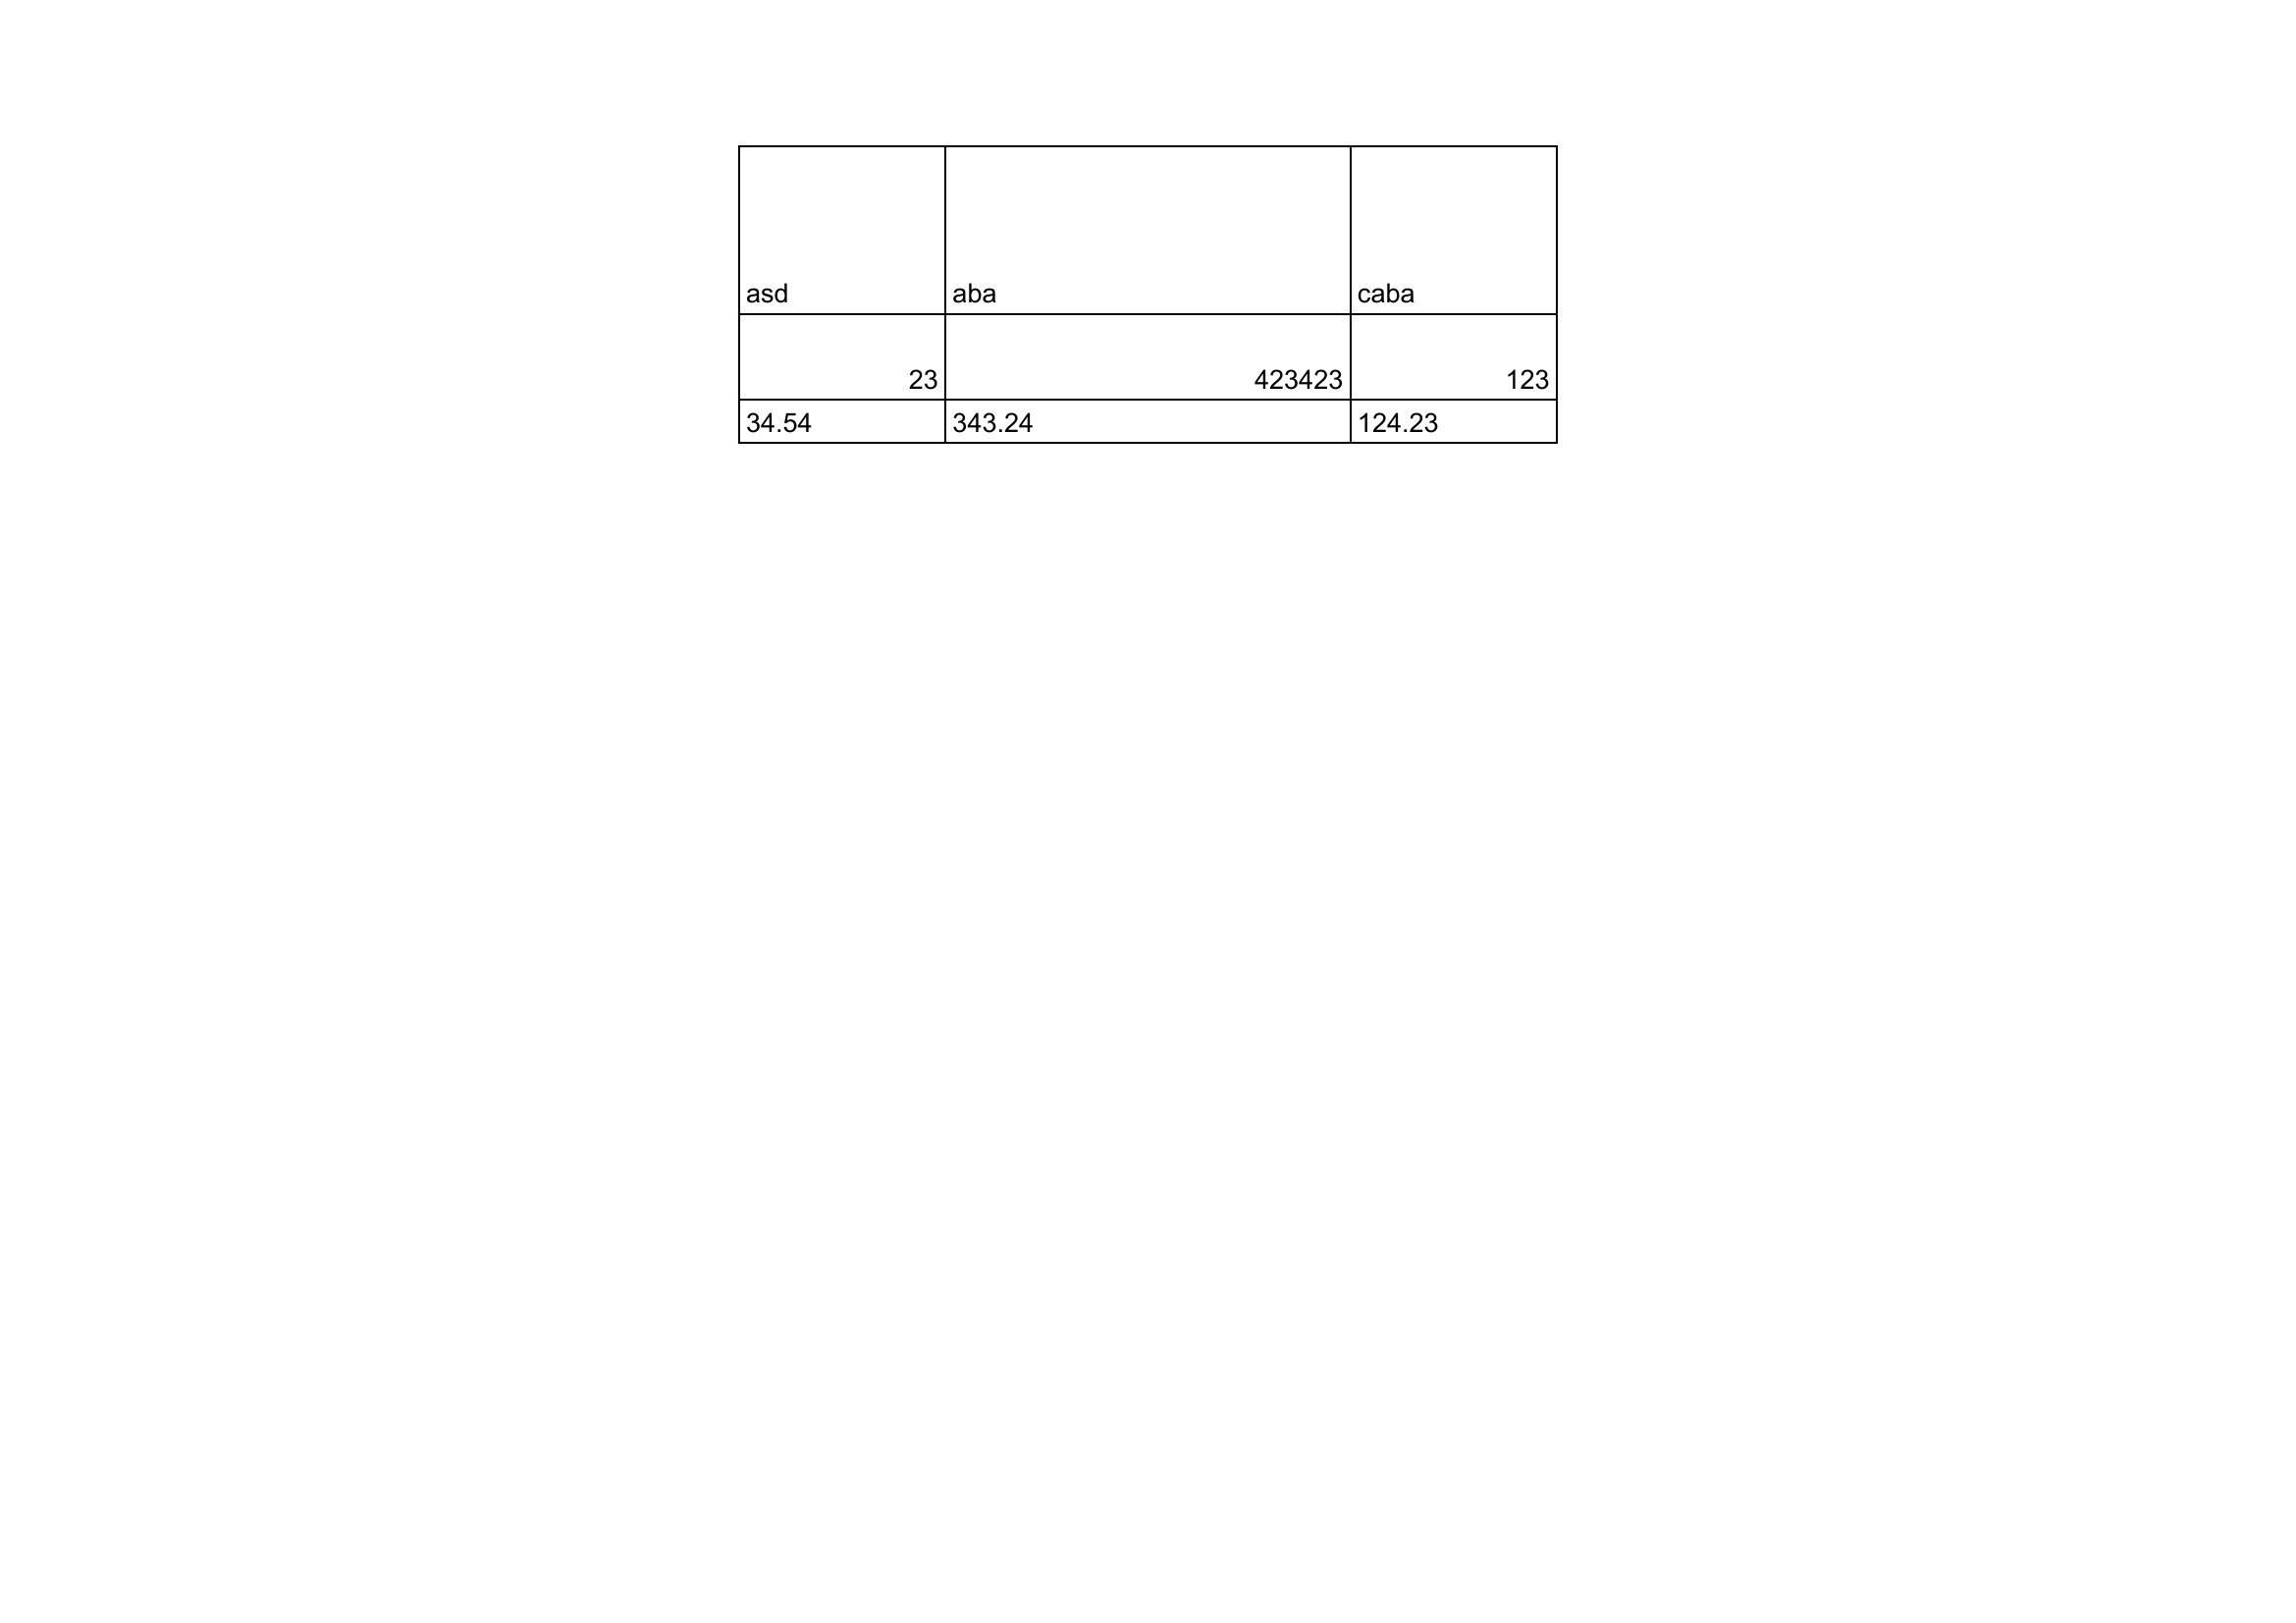

In [50]:
Image.fromarray(image)

Выберем все прямоугольные контуры:

In [51]:
images = convert_from_path('test2.pdf')
image = np.array(images[0])

imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 97, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour_len_4 = []

for contour in contours:
    if contour.shape[0] == 4:
        contour_len_4.append(contour)

Посмотрим на их содержимое:

In [52]:
def see_item(image, contours, index):
    
    x_min = min([i[0][0] for i in contours[index]])
    x_max = max([i[0][0] for i in contours[index]])
    
    y_min = min([i[0][1] for i in contours[index]])
    y_max = max([i[0][1] for i in contours[index]])
    
    return Image.fromarray(image[y_min:y_max, x_min:x_max]).convert('L')

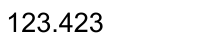

In [53]:
see_item(image, contour_len_4, 1)

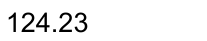

In [54]:
see_item(image, contour_len_4, 2)

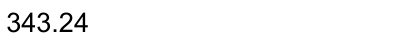

In [55]:
see_item(image, contour_len_4, 3)

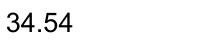

In [56]:
see_item(image, contour_len_4, 4)

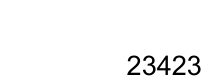

In [57]:
see_item(image, contour_len_4, 5)

Таким образом мы получили содержимое ячеек таблицы

## 3)

Соберем из этих ячеек полноценную таблицу:

In [58]:
def contours_to_corners(contours, max_area):
    result = []
    
    for contour in contours:
        x_min = min([i[0][0] for i in contour])
        x_max = max([i[0][0] for i in contour])

        y_min = min([i[0][1] for i in contour])
        y_max = max([i[0][1] for i in contour])
        
        if (y_max - y_min) * (x_max - x_min) < max_area:
            result.append([x_min, y_min, x_max, y_max])
            
    return result

In [59]:
corners = contours_to_corners(contour_len_4, 2000 * 1000)

In [60]:
corners.sort()

In [61]:
corners

[[649, 150, 856, 318],
 [649, 321, 856, 405],
 [649, 408, 856, 449],
 [859, 150, 1268, 318],
 [859, 321, 1268, 405],
 [859, 408, 1268, 449],
 [1272, 150, 1479, 318],
 [1272, 321, 1479, 405],
 [1272, 408, 1479, 449],
 [1482, 150, 1689, 318],
 [1482, 321, 1689, 405],
 [1482, 408, 1689, 449]]

In [62]:
def image_from_corners(image, corners):
    x_min, y_min, x_max, y_max = corners
    return Image.fromarray(image[y_min:y_max, x_min:x_max]).convert('L')

In [63]:
def from_corners_get_array(image, corners):
    n = 1
    size = len(corners)
    for i in range(1, size):
        if corners[i][0] == corners[i - 1][0]:
            n += 1
        else:
            break
    m = size // n
    
    output = [[None for j in range(m)]for i in range(n)]
    
    for i in range(size):
        output[i % n][i // n] = pytesseract.image_to_string(image_from_corners(image, corners[i]))
    
    return output

In [64]:
output_array = from_corners_get_array(image, corners)

In [65]:
my_array = np.array(output_array)

In [66]:
my_array

array([['asd\n\x0c', 'aba\n\x0c', 'caba\n\x0c', 'asd\n\x0c'],
       ['23\n\x0c', '423423\n\x0c', '123\n\x0c', '23423\n\x0c'],
       ['34.54\n\x0c', '343.24\n\x0c', '124.23\n\x0c', '123.423\n\x0c']],
      dtype='<U9')

In [67]:
df = pd.DataFrame(my_array, columns=[f'Column{i}' for i in range(my_array.shape[1])])

In [68]:
df

,Column0,Column1,Column2,Column3
0,asd\n,aba\n,caba\n,asd\n
1,23\n,423423\n,123\n,23423\n
2,34.54\n,343.24\n,124.23\n,123.423\n


# TASK 3

Для решения последней задачи я бы воспользовался нейронными сетями для сегментации (нахождения) подобных таблиц. 

Для этого необходимо иметь датасет изображений с подобными таблицами (размеченный) и сделать Fine Tuning U-Net-подобной архитектуты на наших данных (даже неразмеченного датасета с таблицами я найти не смог  :( ). 

Стоит также заметить, что мы хотим находить все такие таблицы в нашем PDF документе (иными словами, устремить Recall по количеству найденных таблиц к единице). При такой постановке мы, вероятно, часто будем выделять что-то лишнее. В этом случае стоит сделать диалоговое окошко с пользователем нашего приложения, где мы будем предлагать выделенные нами элементы (в которых мы не сильно уверены), а пользователь будет нам показывать, какие из них действительно являются нужными ему таблицами